<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-basics-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizers with TensorFlow 2 Keras Layers

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
tf.random.set_seed(42)

In [3]:
!nvidia-smi

Sun Feb 16 17:55:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 431.86       Driver Version: 431.86       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   35C    P8     5W /  N/A |     90MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# for RAdam
# !pip install tensorflow_addons

In [5]:
# https://github.com/AndreasMadsen/python-lrcurve
# !pip install -q lrcurve

In [6]:
from lrcurve import KerasLearningCurve

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [9]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

cmap = ListedColormap(['#FF6666', '#6666FF'])

font_size=15
title_font_size=25

def meshGrid(x_data, y_data):
    h = .05  # step size in the mesh
#     x_min, x_max = -0.1, 1.1
#     y_min, y_max = -0.1, 1.1

    x_min, x_max = x_data.min() - .1, x_data.max() + .1
    y_min, y_max = y_data.min() - .1, y_data.max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   ax=None, marker_size=100
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      _, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='o', edgecolors='k', s=classes*marker_size)
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='^', edgecolors='k', s=~classes.astype(bool)*marker_size)

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    return ax


## A new challange: predicting a category instead of a continous value

* so far we were inferring a continous value for another
* now we want to infer which category a point in 2d belongs to
* this is called a classification
* since we only have two categories (0/1 or red/blue) this is called a binary classification

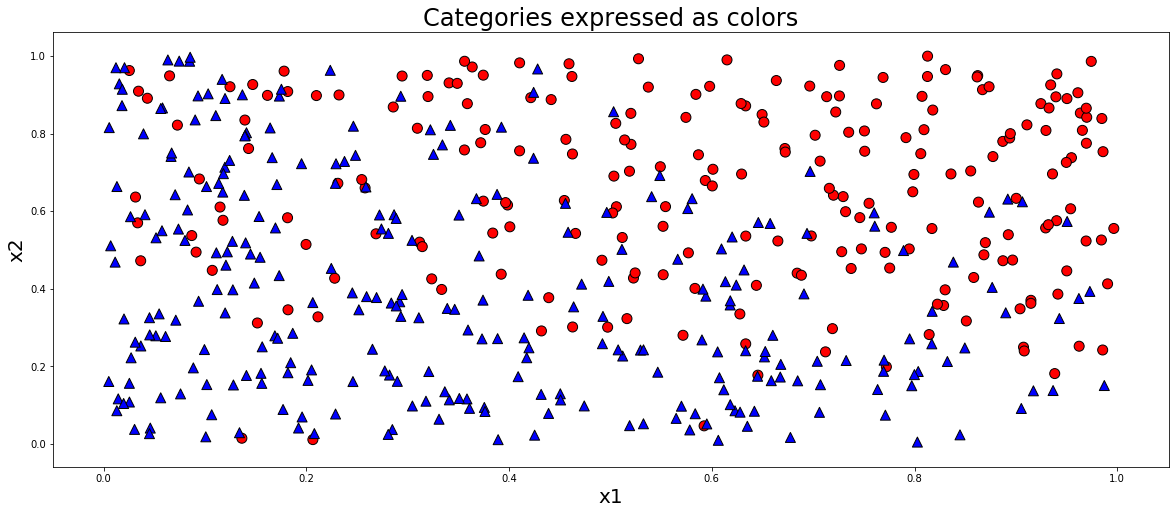

In [10]:
#@title Configure our example { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 500 #@param {type:"slider", min:1, max:1000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.4 #@param {type:"slider", min:0.1, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = np.random.normal(0, noise_level, n)
y_bool = X[:, 1] > m*X[:, 0]+b + noise
y = y_bool.astype(int)

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

size=100

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, marker='o', edgecolors='k', s=y*size);
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, marker='^', edgecolors='k', s=~y_bool*size);

### We have two dimensions as input now

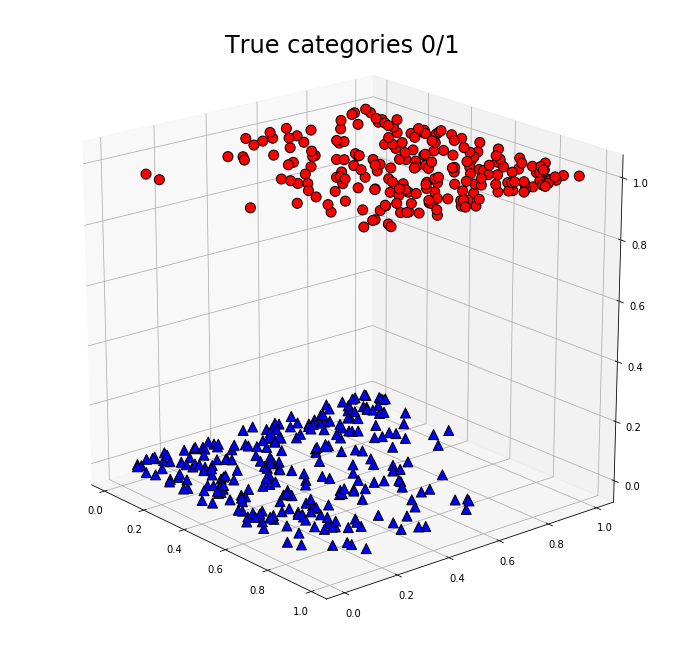

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('True categories 0/1')

# we can have the probability encoded in shade of color
ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=plt.cm.bwr,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y*size)

ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=plt.cm.bwr,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_bool*size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=20, azim=-40)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

# Adam

In [13]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
learning_rate=1e-3 #DEFAULT
# learning_rate=1e-2

from tensorflow.keras.layers import Dense    
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)     
    
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

Wall time: 25.3 s


In [14]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4745322871208191, 0.7875)

In [15]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.48959717512130735, 0.79)

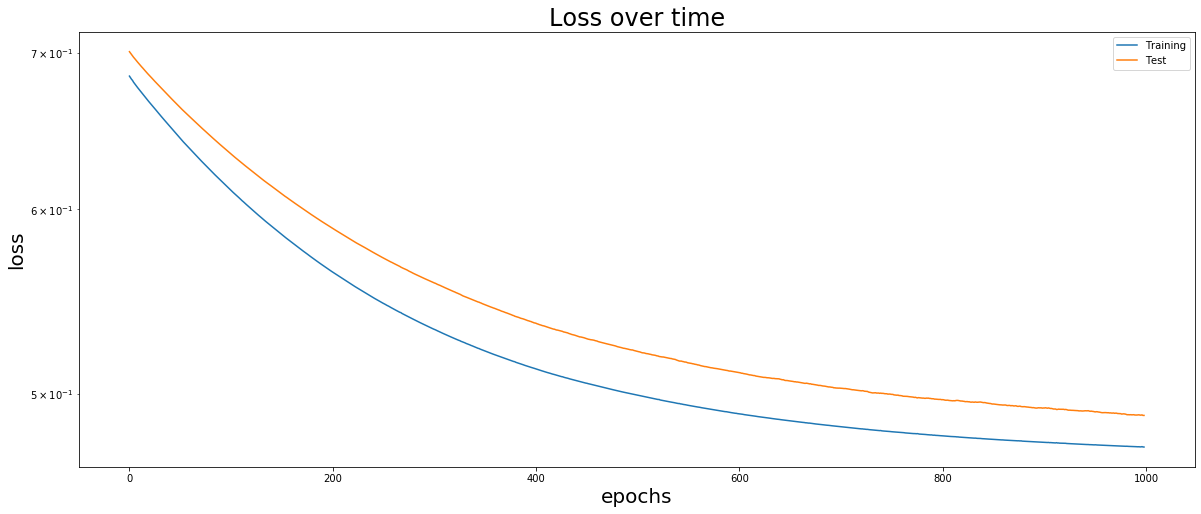

In [16]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

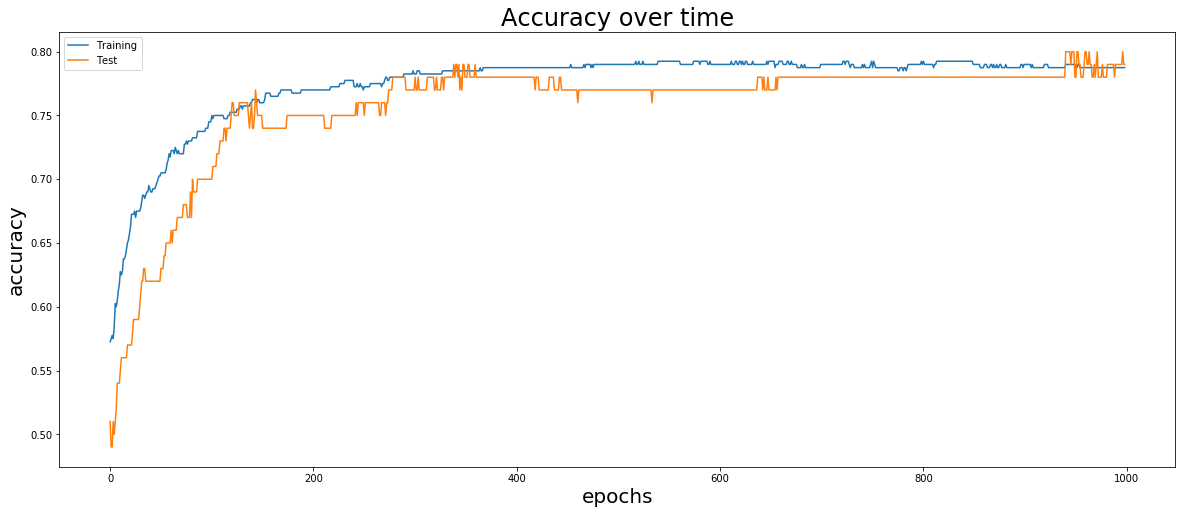

In [17]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

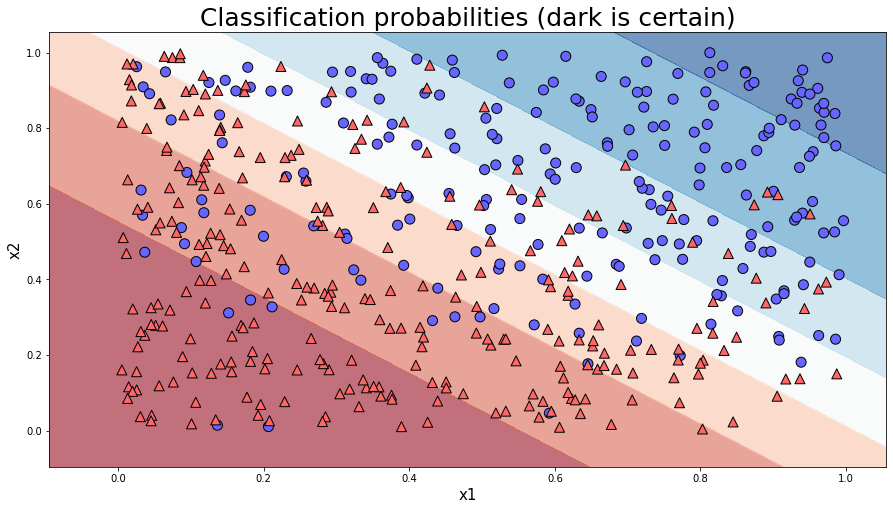

In [18]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# SGD

In [19]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
# learning_rate=1e-3
learning_rate=1e-2 #DEFAULT

from tensorflow.keras.layers import Dense    
    
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)     
    
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

Wall time: 27.4 s


In [20]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.48906344413757324, 0.79)

In [21]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.5091157269477844, 0.78)

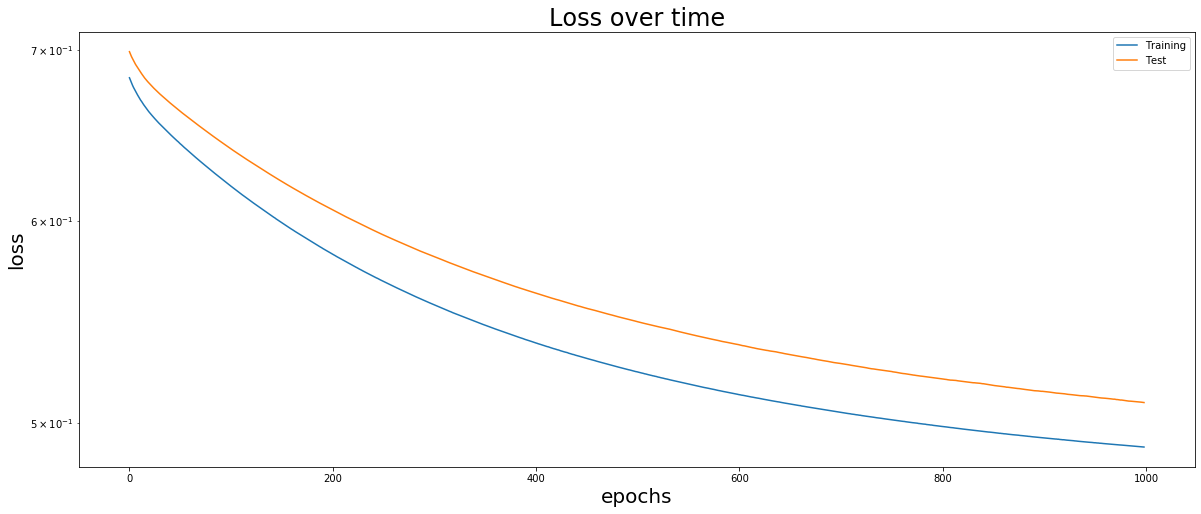

In [22]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

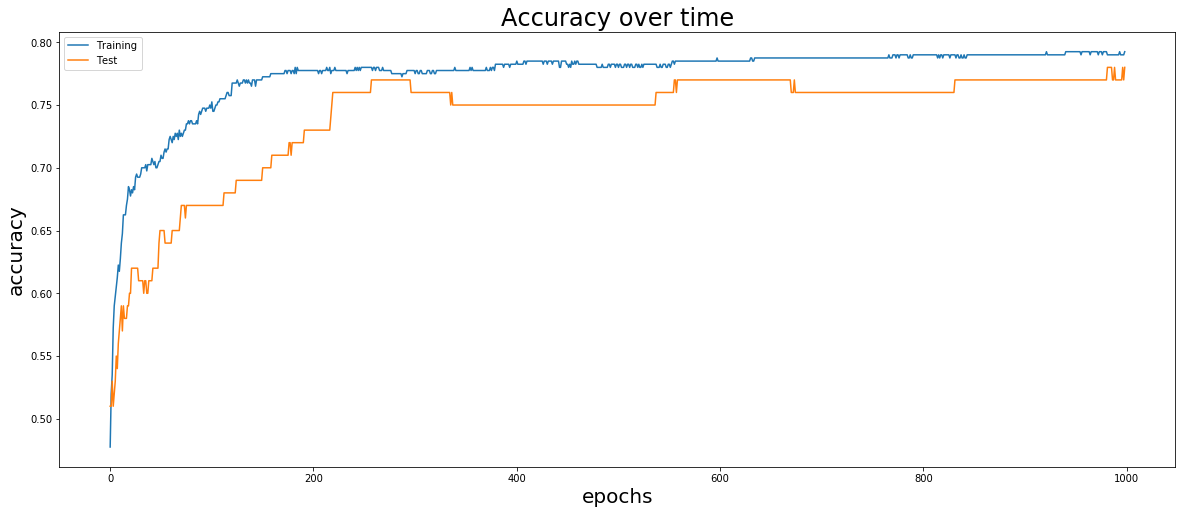

In [23]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

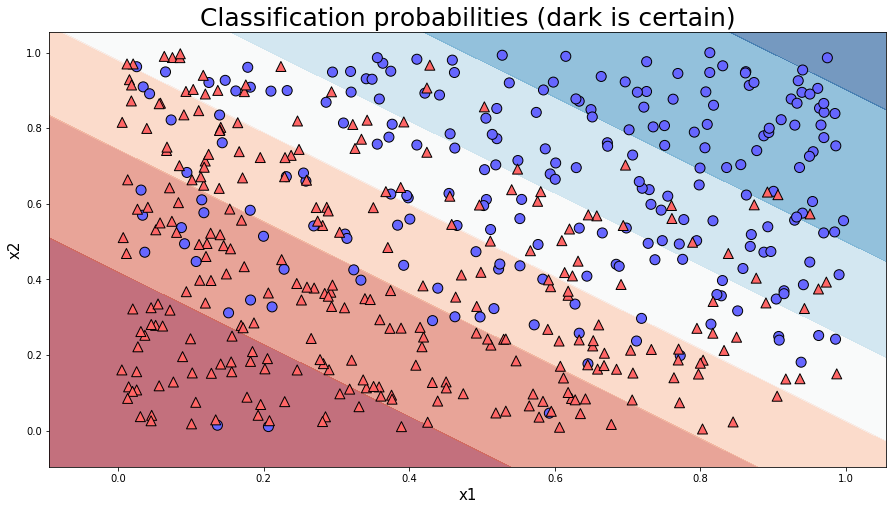

In [24]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# RAdam

* https://www.pyimagesearch.com/2019/09/30/rectified-adam-radam-optimizer-with-keras/
* https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/RectifiedAdam

In [25]:
import tensorflow_addons as tfa

In [26]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
# learning_rate=1e-3

optimizer = tfa.optimizers.RectifiedAdam(
    lr=1e-2,
    total_steps=EPOCHS,
    warmup_proportion=0.00,
    min_lr=1e-2,
)

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

Wall time: 27.5 s


In [27]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4675863289833069, 0.7775)

In [28]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4743138647079468, 0.8)

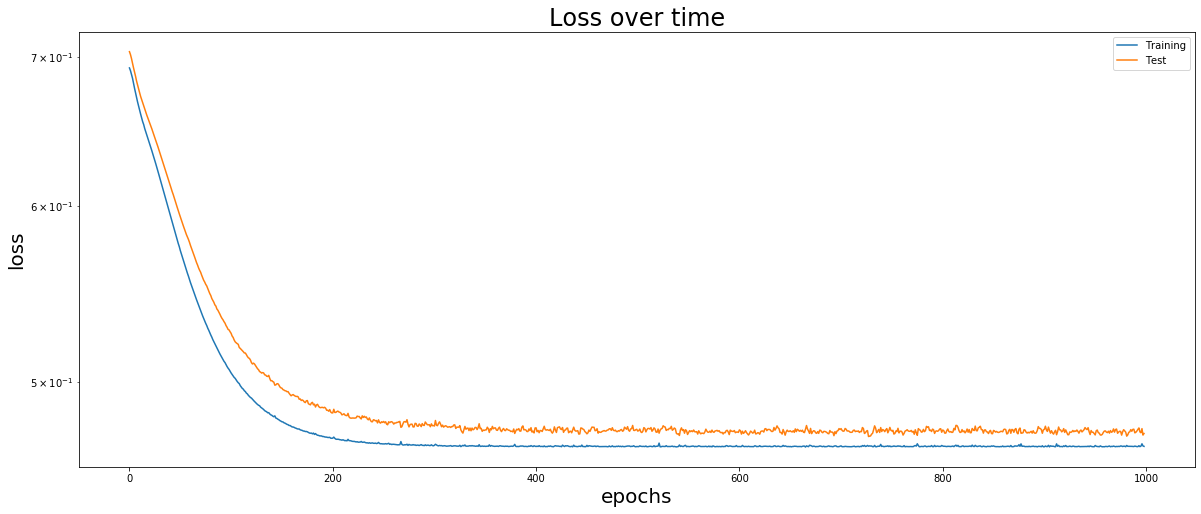

In [29]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

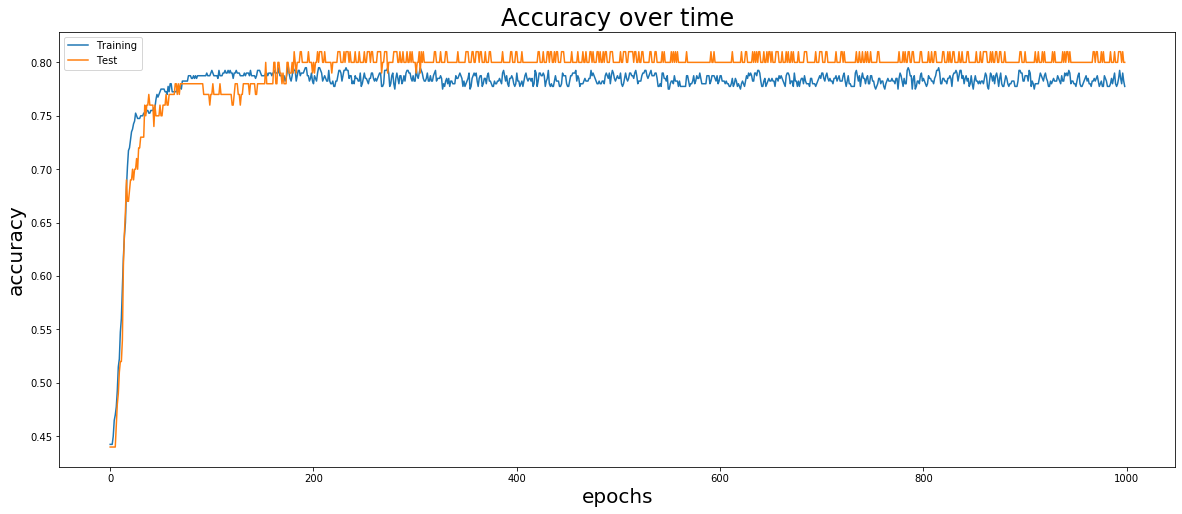

In [30]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

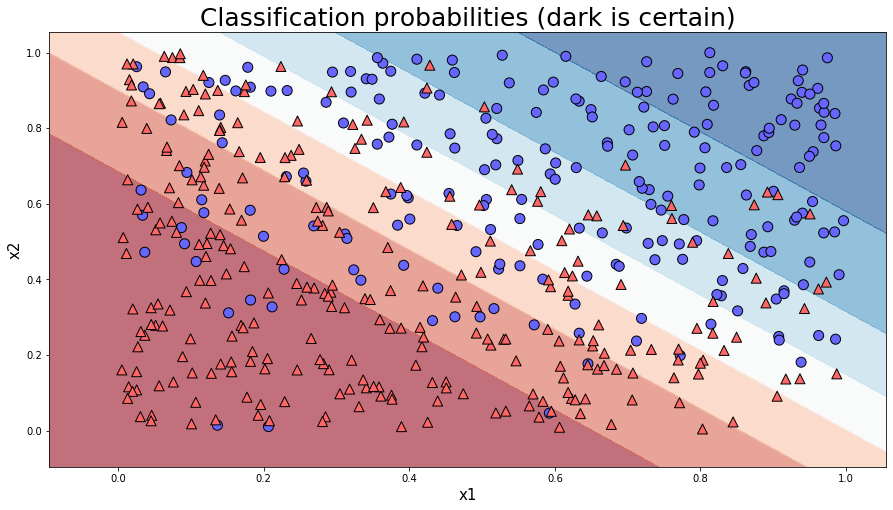

In [31]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Brutal Overcapacity with RAdam

In [32]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
# learning_rate=1e-3

optimizer = tfa.optimizers.RectifiedAdam(
    lr=1e-2,
    total_steps=EPOCHS,
    warmup_proportion=0.01,
    min_lr=1e-3,
)

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

Wall time: 39.4 s


In [33]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.2922936236858368, 0.86)

In [34]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.6396865940093994, 0.72)

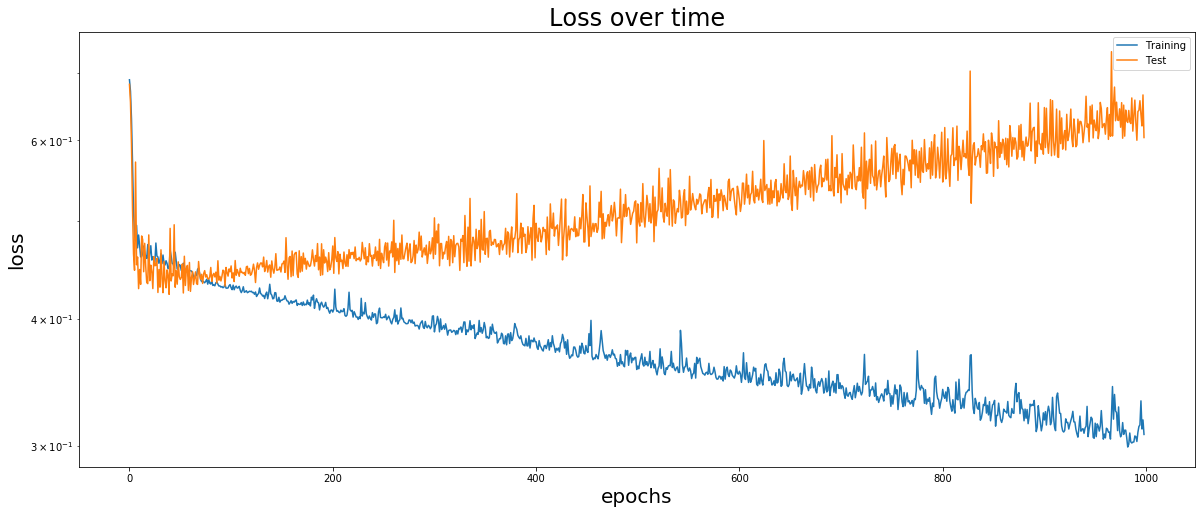

In [35]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

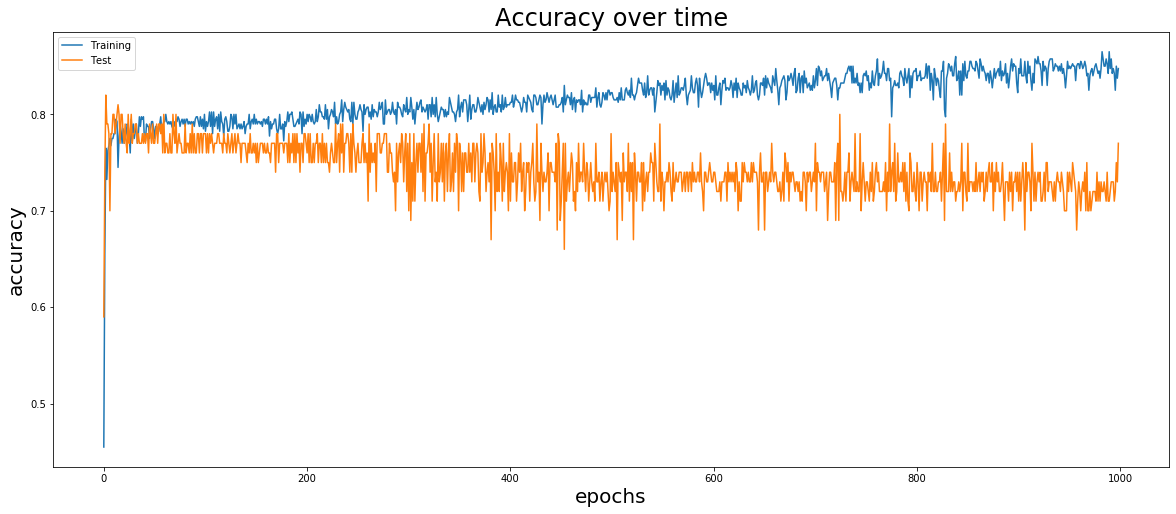

In [36]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

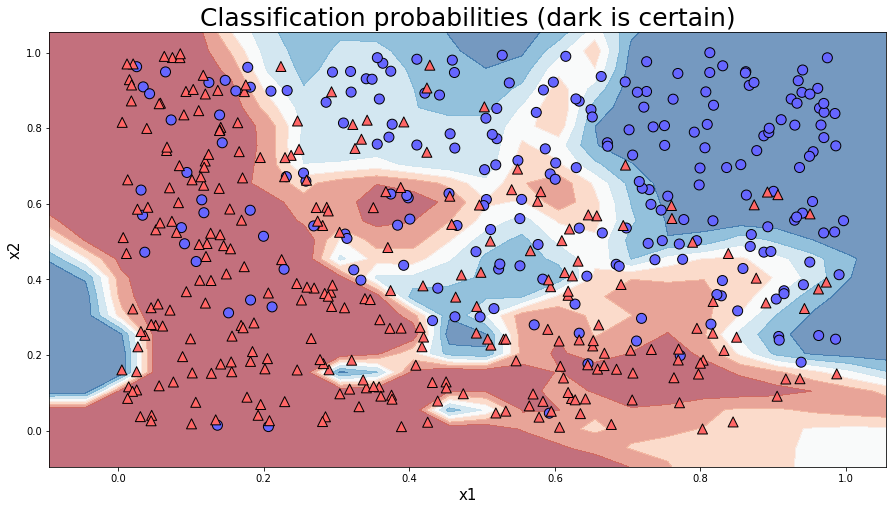

In [37]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Brutal Overcapacity with SGD

In [38]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
# learning_rate=1e-3

optimizer = tf.optimizers.SGD()

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

Wall time: 32.4 s


In [39]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.45158135414123535, 0.795)

In [40]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.44075671434402464, 0.76)

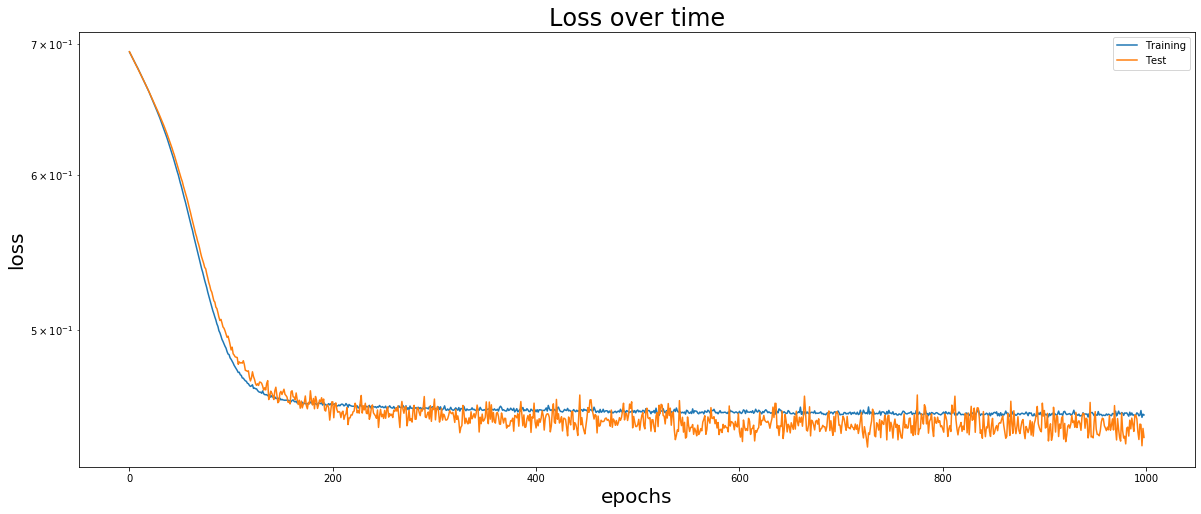

In [41]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

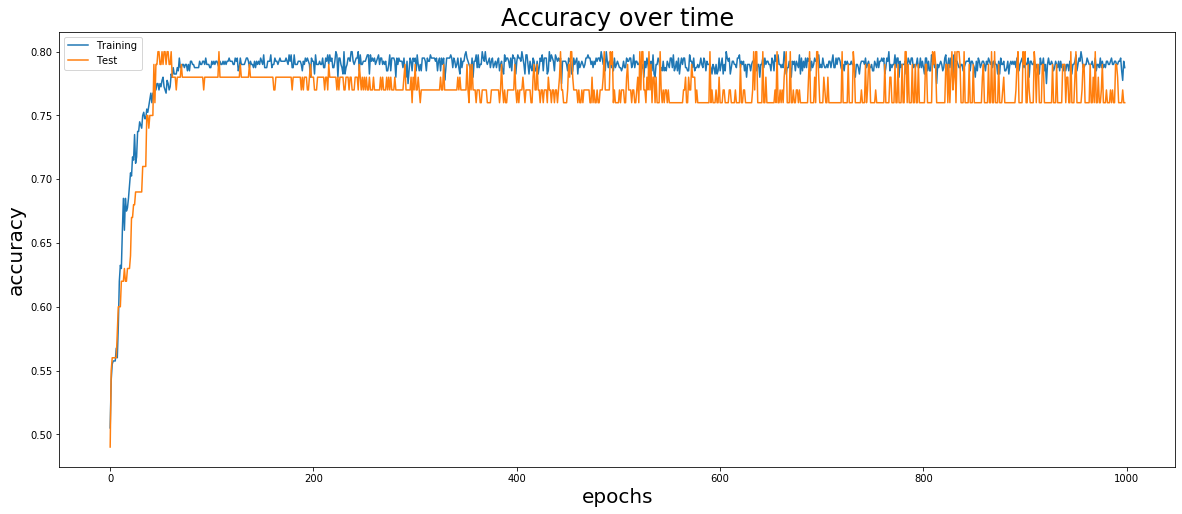

In [42]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

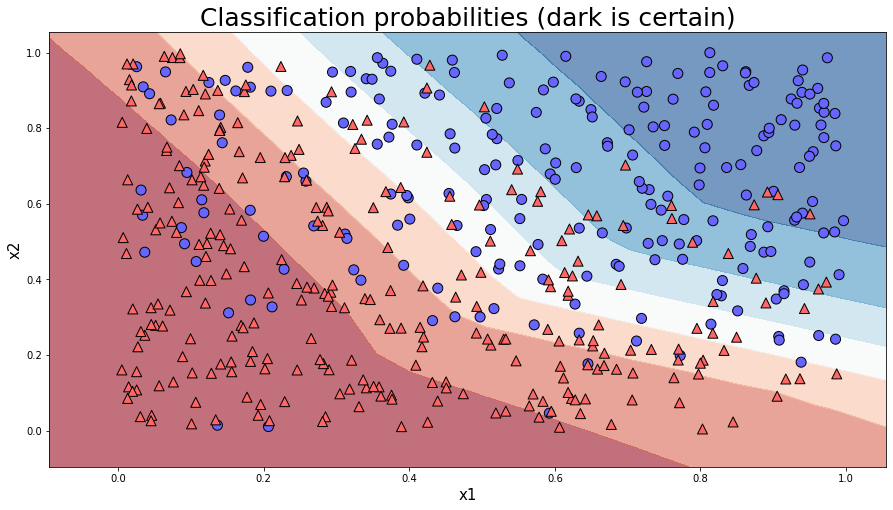

In [43]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Early Stopping with RAdam

* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [44]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
# learning_rate=1e-3

optimizer = tfa.optimizers.RectifiedAdam(
    lr=1e-2,
    total_steps=EPOCHS,
    warmup_proportion=0.01,
    min_lr=1e-3,
)

PATIENCE = 10

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    verbose=0)

Wall time: 1.91 s


In [45]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.46460275173187254, 0.775)

In [46]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4831220293045044, 0.79)

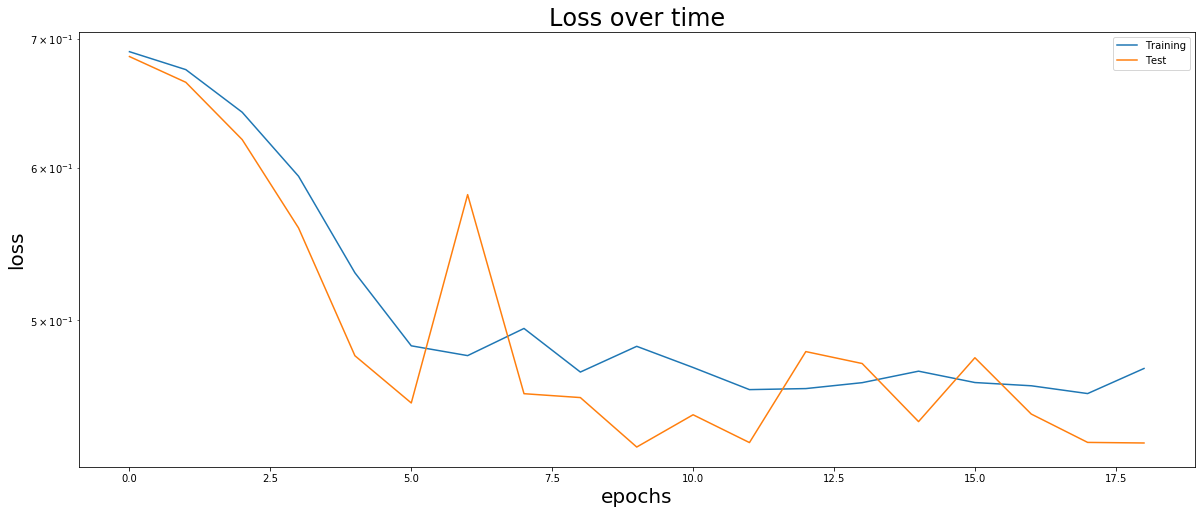

In [47]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

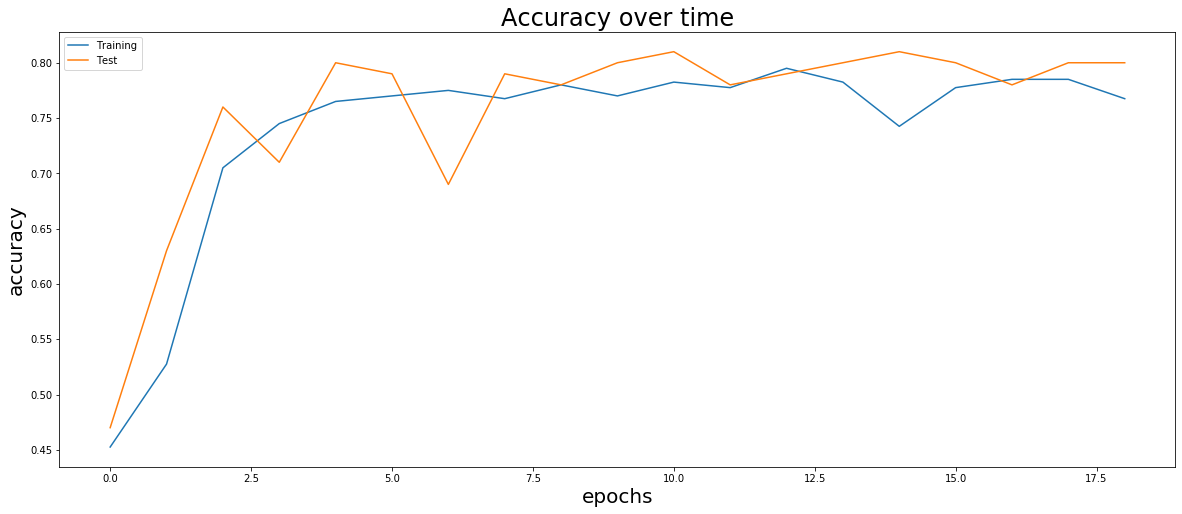

In [48]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

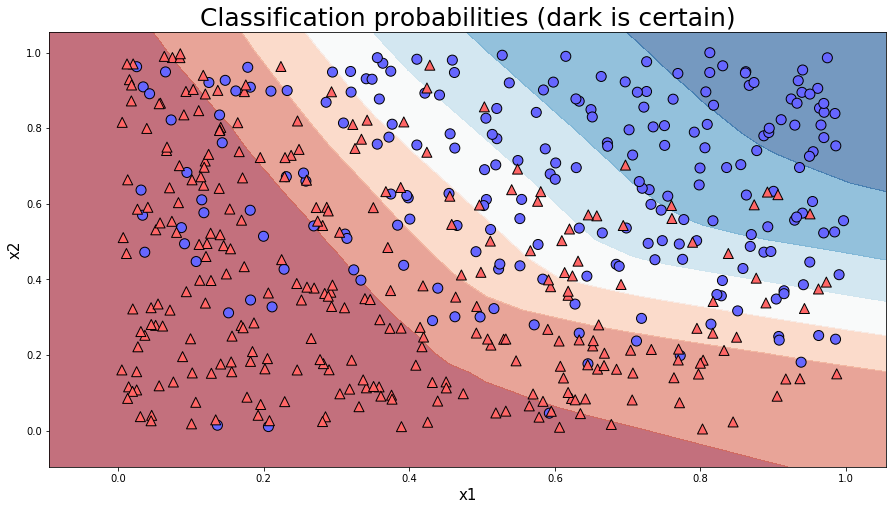

In [49]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");